In [ ]:
import pandas as pd
import ipcalc
import parse_functions as pf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import user_agents as ua
#import janitor

In [ ]:
# Helpers

def filter_other(data, threshold_pct=0.03):
    total = sum(data)
    print(total)
    threshold_abs = threshold_pct * total
    filtered_data = data.loc[data >= threshold_abs]
    excluded_data = data.loc[data < threshold_abs]
    total_excluded = sum(excluded_data)
    filtered_data['Other'] = total_excluded
    return filtered_data

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{:.1f}%\n({v:d})'.format(pct, v=val)
    return my_format

# Vorbereitung: Einlesen der Daten
- Schwierigkeit: Größe des Datensatzes: 10.365.152 Daten (über 10 Milionen)
- keine eindeutiges Trennzeichen in den Daten vorhanden
- kein von Pandas vorgefertigter Import für Log Dateien

In [ ]:
# Source: https://mmas.github.io/read-apache-access-log-pandas
access_log = pd.read_csv(
    'data/access.log',
    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\]\s)',
    engine='python',
    na_values='-',
    header=None,
    usecols=[0, 3, 4, 5, 6, 7, 8],
    names=['ip', 'time', 'request', 'status', 'size', 'referer', 'user_agent'],
    converters={'time': pf.parse_datetime,
                'request': pf.parse_str,
                'status': int,
                'size': int,
                'referer': pf.parse_str,
                'user_agent': pf.parse_str},
    on_bad_lines='warn')

access_log.head()


## Umwandlung in CSV Datei
- Damit nicht jedes Mal Daten neu über das Log eingelesen werden müssen!
- CSV Datei erstellen und für erneutes einlesen nutzbar (geht schneller)

In [ ]:
# Daten in einer CSV Datei speichern
filename = "data/acces_log.csv"
access_log.to_csv(filename)

In [ ]:
# Erzeuge eine Kopie der Daten als "Backup"
access_log_backup = access_log.copy()
len(access_log_backup)

## Daten aus CSV laden

In [ ]:
# Daten aus CSV laden
filename = "data/acces_log.csv"
access_log_csv = pd.read_csv(filename)
len(access_log_csv)
access_log = access_log_csv

## Daten konvertieren & normalisieren
Die in der CSV hinterlegten Daten in die benötigten Datentypen überführen

- time: soll als Datum im Pandas Dataframe hinterlegt werden

In [ ]:
# Typen konvertieren
access_log["time"] = pd.to_datetime(access_log["time"])

# Daten normalisieren
access_log['time'] = access_log['time'].dt.tz_convert('UTC')

# Aufgabe 1: Beliebtestes Produkt

> Analysieren Sie welche Produkte beliebt sind. Entwickeln Sie dazu eine Definition eines beliebten Produktes. Stellen Sie die Ergebnisse anschaulich da.

## Definition

> **Unsere Definition:**  
  Das Produkt mit dein meisten Aufrufen auf dem Webserver

## Ergebnis

Product: Galaxy-J6-Plus-Dual-32GB | ProductID 33968


In [ ]:
most_viewed_products = access_log.loc[access_log['request'].str.contains(r'^GET /product/\d+', na=False)].value_counts(access_log['request'])
print(most_viewed_products[0], most_viewed_products.keys()[0])

# Aufgabe 2

> Untersuchen Sie den Datensatz auf weitere Auffälligkeiten.


## Basisinformationen durch Panda Befehle
- Pandas bietet bereits vordefinierte Befehle um einfache Informationen über die Daten zu ermitteln
- Ein Start mit den Befehlen hilft dabei die Daten zu erkunden
- Speziell bei numerrischen Daten erhält man bereits eine Reihe an spannenden statistischen Informationen, aber auch Daten wie eine solche Log Datei, lohnt es sich beide Befehle kurz anzugucken

### Befehl `.info()`
- Übersicht über die Spalten
- Angabe zu den Datentypen der Spalten

In [ ]:
access_log.info()

### Befehl `.describe()`
- Anzahl der Einträge
- wie viele einzigartige Einträge
- höchste Zahl
- durchschnitt
- einiges mehr

--> Statistische Basisinformationen <br>
--> Parameter `include = 'all'` notwendig, dass auch nicht numerische Daten aufgeführt werden



In [ ]:
access_log.describe(include = 'all')

In [ ]:
access_log.head(5)

In [ ]:
access_log[10000:10200]

ToDo: prüfen ob wir das drin haben wollen / raus nehmen möchten? -> wäre nur ne kleine Hilfestellung zum Zugriff auf Attribute
## Grundlage Zugriff auf Attribute:

- Aufruf möglich durch ``acces_log.ip`` oder ``auch acces_log["ip"]``

In [ ]:
# IP-Adressen mit den meisten Aufrufen 
access_log.value_counts("ip")

# Datenergänzung zur Analyse
- Zur Analyse des Timestamps werden einzelne Spalten für Tag, Stunde (ToDo: Minute? Uhrzeit allgemein) erstellt
- Die neu erstellten Features können für Untersuchungen wir Aufrufe nach Tageszeit verwendet werden

In [109]:
import calendar
access_log["day"] = access_log['time'].dt.weekday
access_log["time_of_day"] = access_log['time'].dt.time
access_log["minute"] = access_log['time'].dt.minute
access_log['hour'] = access_log['time'].dt.hour


In [96]:
print(type(access_log["time_of_day"][0]))
access_log.head()

access_log["time"][0].weekday()

<class 'datetime.time'>


1

# Analyse der herausgearbeiteten Timestamp Eigenschaften 
- Analyse von Tag
- Analyse von Stunden

day
1    2333977
2    2326694
5    1986456
3    1896255
4    1821770
Name: count, dtype: int64


<Axes: xlabel='day'>

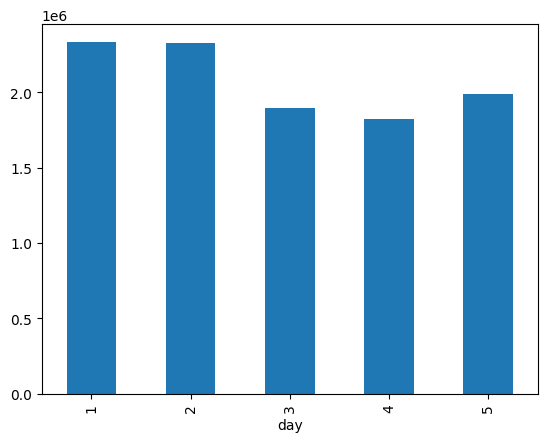

In [105]:
days_count = access_log.value_counts("day")
print(days_count)

days_count.sort_index().plot(kind='bar')

# Ausertung
- Was kann mit den unterschiedlichen Attributen untersucht werden?

## Tagesanzahl
- Die Log-Datei enthält Informationen zu 5 Tagen
- Die ersten beiden Tage haben eine leicht höhere Anzahl an Anfragen, ansonsten aber eine relativ gleiche Verteilung der Last über alle Tage


hour
8     729525
9     728079
10    714435
7     707433
11    671300
6     627247
12    606142
15    573690
13    564234
16    556141
14    545810
5     473162
18    455352
19    450612
17    395118
20    375571
21    294564
4     282567
22    168301
3     125564
23     97473
0      75721
2      74084
1      73027
Name: count, dtype: int64


<Axes: xlabel='hour'>

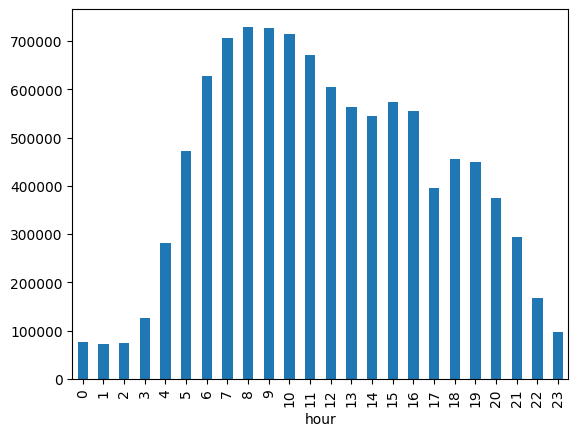

In [107]:
hours_count = access_log.value_counts("hour")
print(hours_count)
hours_count.sort_index().plot(kind='bar')

In [ ]:
# ToDo: irgendwie verwerten? Time of the Day ist schön, aber bringt eigentlich nichts!
access_log.value_counts("time_of_day")

In [ ]:
# ToDo: Entfernen, Minute bringt auch nichts (oder fällt uns was spanneds zur Verwendung noch ein?)
access_log.value_counts("minute")

## Heatmap Tageszeit

Text(0.5, 3.722222222222216, 'Uhrzeit')

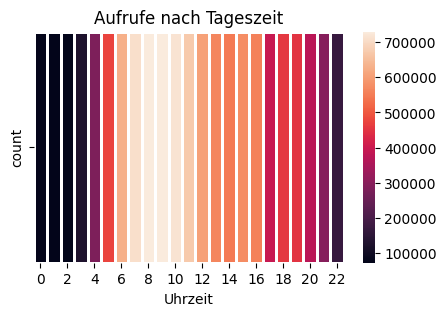

In [110]:
# Wochentag und Tageszeit einlesen
access_log['weekday'] = access_log['time'].dt.weekday
access_log['daytime'] = access_log['time'].dt.hour

daytime_access = access_log.groupby(['daytime']).size().to_frame(name = 'count').reset_index()

fig, ax = plt.subplots(1, 1, figsize = (5, 3))
df_wide = daytime_access.pivot_table(columns='daytime', values='count', aggfunc=lambda x:x)
heatmap = sns.heatmap(df_wide, linewidths=1.0,ax=ax)

ax.set_xlim(0, 23)
ax.set_ylim(0, 1)

heatmap.set_title('Aufrufe nach Tageszeit')
heatmap.set_xlabel('Uhrzeit')


Text(33.22222222222222, 0.5, 'Wochentag')

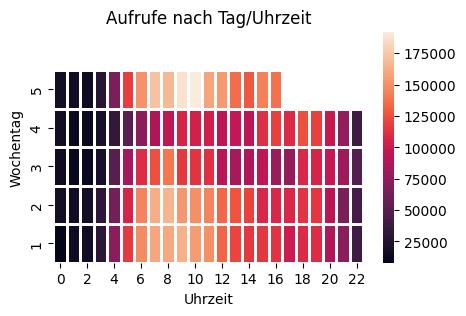

In [111]:
# Wochentag und Tageszeit einlesen
access_log['weekday'] = access_log['time'].dt.weekday
access_log['daytime'] = access_log['time'].dt.hour

daytime_access = access_log.groupby(['weekday', 'daytime']).size().to_frame(name = 'count').reset_index()

fig, ax = plt.subplots(1, 1, figsize = (5, 3))
df_wide = daytime_access.pivot_table(index='weekday',columns='daytime',values='count', aggfunc=lambda x:x)
heatmap = sns.heatmap(df_wide, linewidths=1.0,ax=ax)

ax.set_xlim(0, 23)
ax.set_ylim(0, 6)
# ax.set_yticks(range(0, 7), ['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So'])

heatmap.set_title('Aufrufe nach Tag/Uhrzeit')
heatmap.set_xlabel('Uhrzeit')
heatmap.set_ylabel('Wochentag')

# 1 => Dienstag


## Request Methods

Die folgenden Request Methoden gibt es:  
`GET`, `HEAD`, `POST`, `PUT`, `DELETE`, `CONNECT`, `OPTIONS`, `TRACE` und `PATCH`

In [ ]:
def extract_method(request):
  m = re.match(r'^[A-Z]+', str(request))
  if m:
    return m.group()
  return None

access_log['method'] = access_log['request'].map(extract_method)
access_log.head()

In [ ]:
method_counts = access_log.loc[access_log['method'] != None]['method'].value_counts()

method_counts = filter_other(method_counts, 0.005)

method_counts.plot(kind='pie', title='Request Methods', ylabel='Method', autopct=autopct_format(method_counts))

In [ ]:
method_counts.sort_values(ascending=False).head()

In [ ]:
access_log.loc[access_log['method'] == 'POST'].head()

## User Agents, Browser & OS

In [ ]:
agents = access_log['user_agent'].map(lambda agent: ua.parse(str(agent)))
access_log['browser_family'] = agents.map(lambda agent: agent.browser.family)
access_log['os_family'] = agents.map(lambda agent: agent.os.family)
access_log['device_family'] = agents.map(lambda agent: agent.device.family)
access_log['device_brand'] = agents.map(lambda agent: agent.device.brand)
access_log['device_model'] = agents.map(lambda agent: agent.device.model)
access_log['is_mobile'] = agents.map(lambda agent: agent.is_mobile)
access_log['is_pc'] = agents.map(lambda agent: agent.is_pc)
access_log['is_bot'] = agents.map(lambda agent: agent.is_bot)

access_log.head()

In [ ]:
browser_family_counts = access_log['browser_family'].value_counts()

browser_family_counts = filter_other(browser_family_counts)

browser_family_counts.plot(kind='pie', title='Browsers', ylabel='Browser', autopct=autopct_format(browser_family_counts))

In [ ]:
os_family_counts = access_log['os_family'].value_counts()

os_family_counts = filter_other(os_family_counts)

os_family_counts.plot(kind='pie', title='OS', ylabel='OS', autopct=autopct_format(os_family_counts))

In [ ]:
bot_counts = access_log['is_bot'].value_counts()

bot_counts.plot(kind='pie', title='Bots', ylabel='Bots', autopct=autopct_format(bot_counts))

### Reevaluation von Aufgabe 1

Ändert sich das Ergebnis, wenn wir Bots ausschließen?

In [ ]:
# Ergebnis von vorher
print('Ergebnis von vorher')
print(most_viewed_products[0], most_viewed_products.keys()[0])

print()

# Neues Ergebnis
print('Neues Ergebnis')
most_viewed_products2 = access_log.loc[access_log['is_bot'] != True].loc[access_log['request'].str.contains(r'^GET /product/\d+', na=False)].value_counts(access_log['request'])
print(most_viewed_products2[0], most_viewed_products2.keys()[0])

print()

# Evaluate
if most_viewed_products.keys()[0] == most_viewed_products2.keys()[0]:
    print('Gleiches Ergebnis')
else:
    print('Ergebnis verändert')
print('Differenz:', most_viewed_products[0] - most_viewed_products2[0], 'Bot-Aufrufe')

## Fehler

In [ ]:
status_counts = access_log['status'].value_counts()

status_counts = filter_other(status_counts, 0.01)

status_counts.plot(kind='pie', title='Status', ylabel='Status Code', autopct=autopct_format(status_counts))

In [ ]:
error_counts = access_log['status'].map(lambda status: status >= 400).value_counts()

error_counts.plot(kind='pie', title='Failed requests', ylabel='Error?', autopct=autopct_format(error_counts))

In [ ]:
error_logs = access_log.loc[access_log['status'] >= 400]

error_code_counts = error_logs['status'].value_counts()

error_code_counts = filter_other(error_code_counts, 0.01)

error_code_counts.plot(kind='pie', title='Error', ylabel='Error Code', autopct=autopct_format(error_code_counts))

In [ ]:
error_logs = access_log.loc[access_log['status'] != 200]
error_logs.head()

# WIP

In [ ]:
city_ip4 = pd.read_csv('data/geo-city/GeoLite2-City-Blocks-IPv4.csv')
city_ip4.head()

In [ ]:
locations = pd.read_csv('data/geo-city/GeoLite2-City-Locations-de.csv')
locations.head()

In [ ]:
copy = access_log.copy()
copy['ip_n'] = pf.ip_to_int(copy['ip'])
copy.head()

In [ ]:
#print(city_ip4['network'].map(lambda network: ipcalc.Network(network)))

def get_network_borders(network):
    ip_network = ipcalc.Network(network)
    if len(ip_network) > 0:
        return [int(ip_network[0]), int(ip_network[-1])]
    return [0, 0]

# print(get_network_borders('1.0.8.0/21'))

# print(city_ip4['network'][0:5].map(lambda network: get_network_borders(network)))

city_ip4['ip_range'] = city_ip4['network'].map(lambda network: ipcalc.Network(network))
city_ip4['ip_first'] = city_ip4['ip_range'].map(lambda ip: int(ip[0])).astype('int32')
city_ip4['ip_last'] = city_ip4['ip_range'].map(lambda ip: int(ip[-1])).astype('int32')

# city_ip4['ip_first'] = pf.ip_to_int(city_ip4['network'].map(lambda network: ipcalc.Network(network)[0]))
# city_ip4['ip_last'] = pf.ip_to_int(city_ip4['network'].map(lambda network: ipcalc.Network(network)[-1]))

city_ip4.head()

In [ ]:
# ip = 16778240
# filtered = city_ip4.loc[city_ip4['ip_first'].le(ip)].loc[city_ip4['ip_last'].ge(ip)]
# # filtered = filtered.loc[filtered['ip_last'].ge(ip)]
# filtered.head()

# copy['ip_n'][0:5].map(lambda ip: city_ip4.loc[city_ip4['ip_first'].le(ip)].loc[city_ip4['ip_last'].ge(ip)]['network'])


# pd.concat([
#     copy.loc[i, :].reset_index(drop=True),
#     city_ip4.loc[j, :].reset_index(drop=True)
# ], axis=1).append(
#     copy[~np.in1d(np.arange(len(copy)), np.unique(i))],
#     ignore_index=True, sort=False
# )

# copy.conditional_join(city_ip4, ('ip_n', 'ip_first', '>='), ('ip_n', 'ip_last', '<='))

ips = copy['ip_n'].unique()
ip_map = pd.DataFrame(ips, columns=['ip_n'])
ip_map.conditional_join(city_ip4, ('ip_n', 'ip_first', '>='), ('ip_n', 'ip_last', '<='))



# copy['network'] = copy['ip_n'].map(lambda ip: city_ip4.loc[city_ip4['ip_first'].le(ip)].loc[city_ip4['ip_last'].ge(ip)]['network'])
# copy.head()

In [ ]:
# ip = 16778240
# filtered = city_ip4.loc[city_ip4['ip_first'].le(ip)].loc[city_ip4['ip_last'].ge(ip)]
# # filtered = filtered.loc[filtered['ip_last'].ge(ip)]
# filtered.head()

# copy['ip_n'][0:5].map(lambda ip: city_ip4.loc[city_ip4['ip_first'].le(ip)].loc[city_ip4['ip_last'].ge(ip)]['network'])


# pd.concat([
#     copy.loc[i, :].reset_index(drop=True),
#     city_ip4.loc[j, :].reset_index(drop=True)
# ], axis=1).append(
#     copy[~np.in1d(np.arange(len(copy)), np.unique(i))],
#     ignore_index=True, sort=False
# )

# copy.conditional_join(city_ip4, ('ip_n', 'ip_first', '>='), ('ip_n', 'ip_last', '<='))

ips = copy['ip_n'].unique()
ip_map = pd.DataFrame(ips, columns=['ip_n'])
ip_map.conditional_join(city_ip4, ('ip_n', 'ip_first', '>='), ('ip_n', 'ip_last', '<='))

# def find_network(ip):
#     m = city_ip4[(city_ip4['ip_first'] <= ip) & (city_ip4['ip_last'] >= ip)]
#     if len(m) > 0:
#         n = m.iloc[0]['network']
#         return n
#     return None

# print(find_network(1400386853))


# ip_map['network'] = ip_map['ip_n'][0:1000].map(find_network)

ip_map.head()



# copy['network'] = copy['ip_n'].map(lambda ip: city_ip4.loc[city_ip4['ip_first'].le(ip)].loc[city_ip4['ip_last'].ge(ip)]['network'])
# copy.head()

## Open Ideas

- [x] Nutzung im Tagesverlauf (UTC) (Flo)
  * Wochentage analysieren
- [ ] IP auf Locations mappen
- [ ] Nutzung nach Tageszeit (korrigiert nach Location / Timezone based on IP)
- [x] Requests außer `GET`? (Flo)
- [x] Aufrufe mit Status `!= 200` => Fehler
- [ ] Referers analysieren
- [ ] Nach Nutzer und Pfaden gruppieren und zählen => Entscheidungsfreudigkeit der Nutzer
- [ ] Korrelation untersuchen
- [ ] Sessions von Nutzern zählen / schätzen
- [x] Browser analysieren (Flo)